# Initial

### Torch:

In [0]:
!pip -q install http://download.pytorch.org/whl/cu92/torch-0.4.1-cp36-cp36m-linux_x86_64.whl
!pip -q install torchvision

tcmalloc: large alloc 1073750016 bytes == 0x5903e000 @  0x7fe31c44d2a4 0x591a07 0x5b5d56 0x502e9a 0x506859 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x504c28 0x502540 0x502f3d 0x507641


### Dask:

In [0]:
# https://stackoverflow.com/questions/49853303/how-to-install-pydot-graphviz-on-google-colab?rq=1
!pip -q install graphviz 
!apt-get install graphviz -qq
!pip -q install pydot

In [0]:
!pip -q install "dask[complete]"

### Pycuda:

In [0]:
# https://medium.com/@iphoenix179/running-cuda-c-c-in-jupyter-or-how-to-run-nvcc-in-google-colab-663d33f53772
# https://developer.nvidia.com/cuda-90-download-archive?target_os=Linux&target_arch=x86_64&target_distro=Ubuntu&target_version=1704&target_type=deblocal
!apt update -qq;
!wget https://developer.nvidia.com/compute/cuda/9.0/Prod/local_installers/cuda-repo-ubuntu1704-9-0-local_9.0.176-1_amd64-deb
!mv cuda-repo-ubuntu1704-9-0-local_9.0.176-1_amd64-deb cuda-repo-ubuntu1704-9-0-local_9.0.176-1_amd64.deb  
!dpkg -i cuda-repo-ubuntu1704-9-0-local_9.0.176-1_amd64.deb
!apt-key add /var/cuda-repo-9-0-local/7fa2af80.pub
!apt-get update -qq;
!apt-get install cuda gcc-5 g++-5 -y -qq;
!ln -s /usr/bin/gcc-5 /usr/local/cuda/bin/gcc;
!ln -s /usr/bin/g++-5 /usr/local/cuda/bin/g++;
#!apt install cuda-9.2;

In [0]:
# http://alisonrowland.com/articles/installing-pycuda-via-pip
# https://codeyarns.com/2015/07/31/pip-install-error-with-pycuda/
import os
PATH = os.environ["PATH"]
os.environ["PATH"] = "/usr/local/cuda-9.2/bin:/usr/local/cuda/bin:" + PATH
os.environ["LD_LIBRARY_PATH"] = "/usr/local/cuda/lib64"
os.environ["CUDA_ROOT"] = "/usr/local/cuda/"

In [0]:
!pip -q install --ignore-installed pycuda

# Import

In [0]:
import numpy as np
import pandas as pd
from multiprocessing import Pool, Process
import torch

In [0]:
import matplotlib.pyplot as plt

# 1. Pool and Process

In [0]:
import multiprocessing as mp
mp.cpu_count()

2

### Pool:

In [0]:
def function(lst):
  arr = np.zeros_like(lst)
  for i in range(lst.shape[0]):
    for j in range(lst.shape[1]):
      arr[i][j] = lst[i][j] ** 2
  return arr

array = np.random.randint(1, 9, (2**10, 10000))
data = np.array_split(array, 2)

In [0]:
data[0].shape

(512, 10000)

In [0]:
%%time
with Pool(2) as p:
  res = p.map(function, data)
  p.close()
  p.join()

CPU times: user 115 ms, sys: 280 ms, total: 396 ms
Wall time: 6.78 s


### Process:

In [0]:
%%time
processes = []
for i in range(2):
  p = Process(target=function, args=(data[i],))
  processes.append(p)
  p.start()
  
for p in processes: p.join()

CPU times: user 3.94 ms, sys: 74.6 ms, total: 78.5 ms
Wall time: 8.02 s


### Graphing:

In [0]:
def function(lst):
  arr = np.zeros_like(lst)
  for i in range(lst.shape[0]):
      arr[i] = lst[i] ** 2
  return arr

In [0]:
import time

def serial(n, start=0):
  times = []
  size = []
  for i in range(start, n):
    s = 10**(i+1)
    size.append(s)
    lst = np.random.randint(1, 7, (s,))
    st = time.time()
    res = function(lst)
    en = time.time()
    times.append(en-st)
  return times, size

def parallel(n, sp, start=0):
  times = []
  size = []
  for i in range(start, n):
    s = 10**(i+1)
    size.append(s)
    lst = np.random.randint(1, 7, (s,))
    splitted = np.split(lst, sp)
    with Pool(sp) as p:
      st = time.time()
      res = p.map(function, splitted)
      en = time.time()
    times.append(en-st)
  return times, size

def parallel2(n, sp, start=0):
  """ 
    sp: Number of splits of array and number of processes
    start: Change it so that split function is able to split
  """
  times = []
  size = []
  for i in range(start, n):
    s = 10**(i+1)
    size.append(s)
    lst = np.random.randint(1, 7, (s,))
    splitted = np.split(lst, sp)
    processes = []
    st = time.time()
    for j in range(sp):
      p = Process(target=function, args=(splitted[j],))
      processes.append(p)
    for p in processes: p.start()
    for p in processes: p.join()
    en = time.time()
    times.append(en-st)
  return times, size

In [0]:
%%time
t1, s1 = serial(6)

CPU times: user 409 ms, sys: 17.5 ms, total: 427 ms
Wall time: 431 ms


In [0]:
%%time
t2, s2 = parallel(6, 2)

CPU times: user 60 ms, sys: 618 ms, total: 678 ms
Wall time: 1.91 s


In [0]:
%%time
t3, s3 = parallel2(6, 2)

CPU times: user 32.7 ms, sys: 492 ms, total: 524 ms
Wall time: 1.01 s


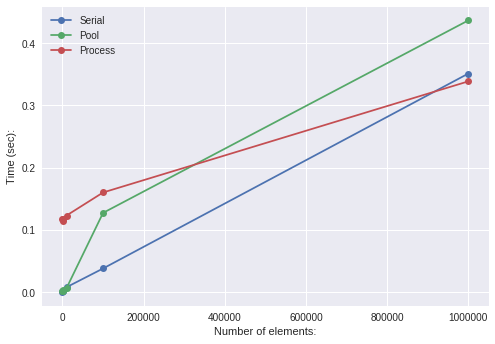

In [0]:
plt.plot(s1, t1, "o-", label="Serial")
plt.plot(s2, t2, "o-", label="Pool")
plt.plot(s3, t3, "o-", label="Process")
plt.legend()
plt.xlabel("Number of elements:")
plt.ylabel("Time (sec):")
plt.show()
# Our task is not that heavy, results here may vary unexpectedly.

# 2. Threading

In [0]:
from threading import Thread as trd
import queue
q = queue.Queue()

In [0]:
def function(lst):
  arr = np.zeros_like(lst)
  for i in range(lst.shape[0]):
    for j in range(lst.shape[0]):
      arr[i][j] = lst[i][j] * lst[i][j]
  return arr

array = np.random.randint(1, 10, (1000, 10000))
data = np.array_split(array, 2)

In [0]:
%%time
res = function(array)

CPU times: user 934 ms, sys: 16.4 ms, total: 950 ms
Wall time: 954 ms


In [0]:
%%time
# By using Queue this way you can get result of function without
# modifying your function.
t1 = trd(target=lambda q, args1: q.put(function(args1)), args=(q, data[0]))
t2 = trd(target=lambda q, args1: q.put(function(args1)), args=(q, data[1]))

t1.start()
t2.start()

t1.join()
t2.join()

res1 = q.get()
res2 = q.get()

CPU times: user 489 ms, sys: 22.4 ms, total: 511 ms
Wall time: 496 ms


In [0]:
q.empty()

True

# 3. Dask

In [0]:
from dask import delayed as delay

@delay
def add(x, y): return x+y
@delay
def sq(x): return x**2
@delay
def sum(x): 
  sum=0
  for i in range(len(x)): sum+=x[i]
  return sum

In [0]:
inputs = list(np.arange(1, 11))

res = [sq(n) for n in inputs]
res = [add(n, m) for n, m in zip(res[::2], res[1::2])]
res = sum(res)

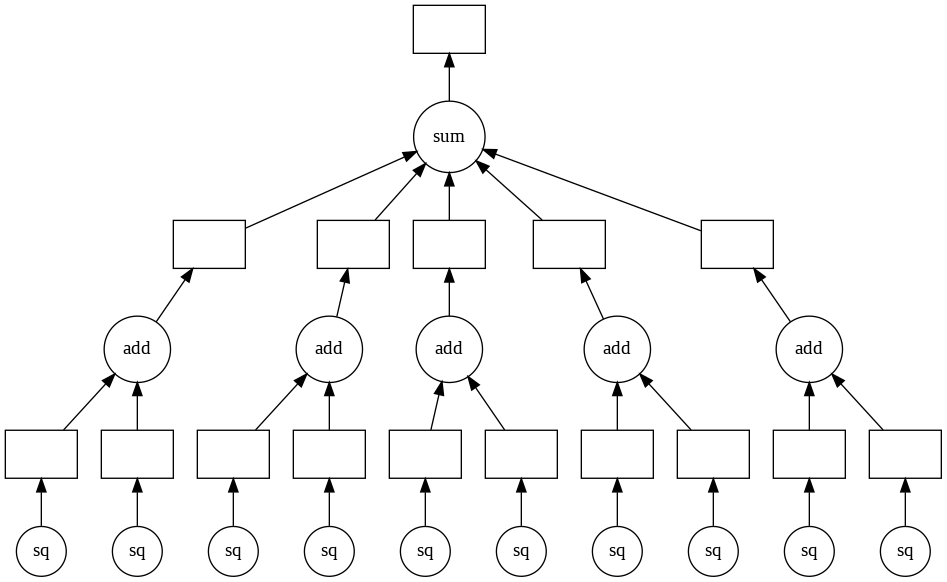

In [0]:
res.visualize()

In [0]:
res.compute()

385

# 4. torch.multiprocessing

In [0]:
import torch.multiprocessing as mp_
mp = mp_.get_context('spawn')

In [0]:
a = torch.zeros((1000, 1000))
b = torch.zeros_like(a).cuda()

In [0]:
def func(arr):
  for i in range(arr.shape[0]):
    for j in range(arr.shape[1]):
      arr[i][j] += (i+j)
      arr[i][j] *= arr[i][j]
  return arr

In [0]:
%%time
res = func(a)

CPU times: user 22 s, sys: 1.79 s, total: 23.8 s
Wall time: 23.8 s


In [0]:
%%time
res = func(b)

CPU times: user 2min 56s, sys: 54.9 s, total: 3min 51s
Wall time: 3min 51s


### Training Model using multiple processes:

In [0]:
import torch.multiprocessing as mp_
mp = mp_.get_context('spawn')
import torch.nn as nn

In [0]:
from sklearn.datasets import make_classification
from torch.utils.data import DataLoader, TensorDataset
X, y = make_classification(n_samples=10000, )

dataset = TensorDataset(torch.FloatTensor(X), torch.DoubleTensor(y))
data_loader = DataLoader(dataset, batch_size=8)

In [0]:
n_in = 20; n_out = 1        
        
model = nn.Sequential(nn.Linear(n_in, 15),
                      nn.ReLU(),
                      nn.Linear(15, 10),
                      nn.ReLU(),
                      nn.Linear(10, 5),
                      nn.ReLU(),
                      nn.Linear(5, n_out),
                      nn.Sigmoid())

model.share_memory() # Required for 'fork' method to work

Sequential(
  (0): Linear(in_features=20, out_features=15, bias=True)
  (1): ReLU()
  (2): Linear(in_features=15, out_features=10, bias=True)
  (3): ReLU()
  (4): Linear(in_features=10, out_features=5, bias=True)
  (5): ReLU()
  (6): Linear(in_features=5, out_features=1, bias=True)
  (7): Sigmoid()
)

In [0]:
def train(model):
    for data, labels in data_loader:
        optimizer.zero_grad()
        loss_fn(model(data), labels).backward()
        optimizer.step()  # This will update the shared parameters

In [0]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9, nesterov=True)
loss_fun = torch.nn.BCELoss()

In [0]:
processes = []
for i in range(4): # No. of processes
    p = mp.Process(target=train, args=(model,))
    p.start()
    processes.append(p)
for p in processes: p.join()

In [0]:
sum=0
for data, labels in data_loader:
  with torch.no_grad():
    res = model(data)
    res[res>=0.7] = 1
    res[res<0.7] = 0
    sum += (res.numpy()!=labels.float().numpy()).diagonal().sum()

    
sum/10000

0.4994

# 5. Pycuda (Optional)

In [0]:
import pycuda.driver as cuda
import pycuda.autoinit
from pycuda.compiler import SourceModule

In [0]:
import numpy
a = numpy.random.randint(1, 9, (10000, 10000))
a = a.astype(numpy.float32) # Most nVidia devices support single precision

In [0]:
# The main drawback of Pycuda is that you will have to write C code
# to perform any task and pass it to SourceModule...

mod = SourceModule("""
  __global__ void double(float *a)
  {
    int idx = threadIdx.x + threadIdx.y*blockDim.x;
    a[idx] *= 2;
  }
  """)

# As we saw in Numba post, you have to know which thread we are in to compute index(s) to operate on.
# Here we get that from threadId.

In [0]:
# Get reference to function and initialize it, passing array and block size (4x4).
func = mod.get_function("double")

In [0]:
## a_gpu = cuda.mem_alloc(a.nbytes) # Allocate memory on GPU
## cuda.memcpy_htod(a_gpu, a) # Send array to GPU. Now your array is within variable a_gpu
### a_gpu = cuda.to_device(a)
### func(a_gpu, block=(4, 4, 1))
### a_doubled = numpy.empty_like(a) # Copy array from gpu to cpu
### cuda.memcpy_dtoh(a_doubled, a_gpu)
### a_doubled[0][0:10], a[0][0:10]

In [0]:
# We can also simply use cuda.InOut which sends array to GPU
# and then retrives back again:
func(cuda.InOut(a), block=(4, 4, 1)) # block takes Block size which can be 3D. Block size gives us number of threads in Block. (No. of threads should be <= 512)
a

In [0]:
# Whereas a grid is 2D and can have max of 1000's of blocks. As before its dimensions give number of blocks. 

#### Examples:

Image: https://raw.githubusercontent.com/andreajeka/CUDAThreadIndexing/master/images/1dgrid3dblock.png


As shown in image, if we use 1D grid and 3D blocks, that is how you can think of it. Each of the thread sub-blocks contain one thread. Structure like this makes indexing of threads in grid easier.

In [0]:
#
# 1D grid and 1D block
#

temp = numpy.zeros((4000,))
temp = temp.astype(numpy.float32)
mod = SourceModule("""
  __global__ void cuda_func(float *a)
  {
    int idx = blockDim.x*blockIdx.x + threadIdx.x;  // Go to block + Go to thread
    if(idx < 4000){
       a[idx] = (float) threadIdx.x; // One thread operating on one index. There are total of (4127)//128 = 32 blocks, each having 128 threads. Total 4096 threads.
    }
  }
  """)
func = mod.get_function("cuda_func")
func(cuda.InOut(temp), grid=((4000+127)//128, 1), block=(128, 1, 1))
temp[-33:]

array([127.,   0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,
        10.,  11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,
        21.,  22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.],
      dtype=float32)

In [0]:
#
# 1D grid and 2D block
#

temp = numpy.zeros((4000,))
temp2 = numpy.zeros((4000,))
temp = temp.astype(numpy.float32)
temp2 = temp2.astype(numpy.float32)
mod = SourceModule("""
  __global__ void cuda_func(float *a, float *b)
  {
    int idx = blockDim.x*blockDim.y*blockIdx.x + blockDim.x* threadIdx.y + threadIdx.x;  // Go to block + Go to row to current thread + Go to thread
    if(idx < 4000){
       a[idx] = (float) threadIdx.x; // One thread operating on one index. There are total of (4063)//64 = 63 blocks, each having (8x8)=64 threads. Total 4032 threads.
       b[idx] = (float) threadIdx.y;
    }
  }
  """)
func = mod.get_function("cuda_func")
func(cuda.InOut(temp), cuda.InOut(temp2), grid=((4000+63)//64, 1), block=(8, 8, 1))
temp[-10:], temp2[-10:]

(array([6., 7., 0., 1., 2., 3., 4., 5., 6., 7.], dtype=float32),
 array([2., 2., 3., 3., 3., 3., 3., 3., 3., 3.], dtype=float32))

In [0]:
#
# 1D grid and 3D block
#

temp = numpy.zeros((4000,))
temp = temp.astype(numpy.float32)
temp2 = numpy.zeros((4000,))
temp2 = temp2.astype(numpy.float32)
temp3 = numpy.zeros((4000,))
temp3 = temp3.astype(numpy.float32)
mod = SourceModule("""
  __global__ void cuda_func(float *a, float *b, float *c)
  {
    int idx = blockDim.x*blockDim.y*blockDim.z*blockIdx.x +  // Go to block 
              blockDim.x*blockDim.y*threadIdx.z +            // Go to z sclice containing thread
              blockDim.x*threadIdx.y +                       // In that slice go to row containing thread
              threadIdx.x;                                   // Go to thread
    if(idx < 4000){
       a[idx] = (float) threadIdx.x; // One thread operating on one index. There are total of (4063)//64 = 63 blocks, each having (4x4x4)=64 threads. Total 4032 threads.
       b[idx] = (float) threadIdx.y;
       c[idx] = (float) threadIdx.z;
    }
  }
  """)
func = mod.get_function("cuda_func")
func(cuda.InOut(temp), cuda.InOut(temp2), cuda.InOut(temp3), grid=((4000+63)//64, 1), block=(4, 4, 4))
temp[-17:], temp2[-17:], temp3[-17:] 

(array([3., 0., 1., 2., 3., 0., 1., 2., 3., 0., 1., 2., 3., 0., 1., 2., 3.],
       dtype=float32),
 array([3., 0., 0., 0., 0., 1., 1., 1., 1., 2., 2., 2., 2., 3., 3., 3., 3.],
       dtype=float32),
 array([0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       dtype=float32))

In [0]:
#
# 2D grid and 3D block
#

temp = numpy.zeros((4000,))
temp = temp.astype(numpy.float32)
temp2 = numpy.zeros((4000,))
temp2 = temp2.astype(numpy.float32)
temp3 = numpy.zeros((4000,))
temp3 = temp3.astype(numpy.float32)
temp4 = numpy.zeros((4000,))
temp4 = temp4.astype(numpy.float32)
temp5 = numpy.zeros((4000,))
temp5 = temp5.astype(numpy.float32)
mod = SourceModule("""
  __global__ void cuda_func(float *a, float *b, float *c, float *d, float *e)
  {
    int idx = gridDim.x*blockDim.x*blockDim.y*blockDim.z*blockIdx.y +      // Go to grid row containing block
              blockDim.x*blockDim.y*blockDim.z*blockIdx.x +                // Go to block
              blockDim.x*blockDim.y*threadIdx.z +                          // Go to slice of block containing thread
              blockDim.x*threadIdx.y +                                     // In that slice go to row containing thread
              threadIdx.x;                                                 // Go to thread
    if(idx < 4000){
       a[idx] = (float) threadIdx.x; // One thread operating on one index. There are total of (8*8) = 64 blocks, each having (4x4x4)=64 threads. Total 4096 threads.
       b[idx] = (float) threadIdx.y;
       c[idx] = (float) threadIdx.z;
       d[idx] = (float) blockIdx.x;
       e[idx] = (float) blockIdx.y;
    }
  }
  """)
func = mod.get_function("cuda_func")
func(cuda.InOut(temp), cuda.InOut(temp2), cuda.InOut(temp3), cuda.InOut(temp4), cuda.InOut(temp5), grid=(8, 8), block=(4, 4, 4))
temp[-17:], temp2[-17:], temp3[-17:], temp4[-17:], temp5[-17:]

(array([3., 0., 1., 2., 3., 0., 1., 2., 3., 0., 1., 2., 3., 0., 1., 2., 3.],
       dtype=float32),
 array([3., 0., 0., 0., 0., 1., 1., 1., 1., 2., 2., 2., 2., 3., 3., 3., 3.],
       dtype=float32),
 array([0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       dtype=float32),
 array([6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6.],
       dtype=float32),
 array([7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7.],
       dtype=float32))

In [0]:
#
# 1D grid and 1D block and only 1 thread
#

temp = numpy.zeros((4000,))
temp = temp.astype(numpy.float32)
mod = SourceModule("""
  __global__ void cuda_func(float *a)
  {
    printf("%d", threadIdx.x);
    for(int i=0; i<4000; i++){
      a[i] = i;
    }
  }
  """)
func = mod.get_function("cuda_func")
func(cuda.InOut(temp), grid=(1, 1), block=(1, 1, 1))
temp[-10:]

array([3990., 3991., 3992., 3993., 3994., 3995., 3996., 3997., 3998.,
       3999.], dtype=float32)

In [0]:
# So on a single thread you can operate on an subarray too. You will have to configure task accordingly.